In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [27]:
# Connect to the database
conn = sqlite3.connect('full_stock_history.db')

In [3]:
data_cts = pd.read_sql_query("""
    SELECT 
        symbol,
        COUNT(*) as data_points
    FROM daily_prices
    GROUP BY symbol
    ORDER BY data_points DESC
""", conn)

In [4]:
data_cts["data_points"].describe(percentiles=[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999])

count     4269.000000
mean      3508.474584
std       3642.619479
min          1.000000
0.1%         1.000000
1%           1.000000
10%         62.800000
20%        631.200000
30%        912.000000
40%       1153.800000
50%       1815.000000
60%       2902.600000
70%       4881.800000
80%       6857.000000
90%       9131.200000
99%      13258.000000
99.9%    15858.000000
max      24366.000000
Name: data_points, dtype: float64

In [5]:
data_times = pd.read_sql_query("""
    SELECT 
        symbol,
        COUNT(*) as data_points,
        MIN(date) as start_date,
        MAX(date) as end_date                             
    FROM daily_prices
    GROUP BY symbol
    ORDER BY data_points DESC
""", conn)

In [6]:
data_times["start_date"] = pd.to_datetime(data_times["start_date"])
data_times["end_date"] = pd.to_datetime(data_times["end_date"])
data_times["start_year"] = data_times["start_date"].dt.year
data_times["end_year"] = data_times["end_date"].dt.year
data_times["n_years"] = data_times["end_year"] - data_times["start_year"]

In [7]:
data_times["n_years"].describe(percentiles=[0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999])

count    4269.000000
mean       13.463340
std        14.383288
min         0.000000
0.1%        0.000000
1%          0.000000
10%         0.000000
20%         2.000000
30%         3.000000
40%         4.000000
50%         7.000000
60%        11.000000
70%        19.000000
80%        27.000000
90%        36.000000
99%        52.000000
99.9%      62.000000
max        97.000000
Name: n_years, dtype: float64

In [8]:
ct_per_year = pd.read_sql_query("""
SELECT 
    symbol,
    strftime('%Y', date) as year,
    COUNT(*) as data_points
FROM daily_prices
GROUP BY symbol, strftime('%Y', date)
ORDER BY symbol, year
""", conn)

In [9]:
ct_per_year["data_points"].describe()

count    61744.000000
mean       242.577060
std         39.381032
min          1.000000
25%        251.000000
50%        252.000000
75%        252.000000
max        254.000000
Name: data_points, dtype: float64

In [10]:
incomplete_years = pd.read_sql_query("""
    SELECT 
        symbol,
        strftime('%Y', date) as year,
        COUNT(*) as trading_days
    FROM daily_prices
    GROUP BY symbol, strftime('%Y', date)
    HAVING trading_days < 245
    ORDER BY symbol, year
""", conn)

In [11]:
ct_per_year["data_points"].value_counts().sort_index(ascending=False).iloc[0:20]

data_points
254     1286
253     9116
252    29747
251    11139
250     5142
249       19
248     1108
247       16
246       10
245        8
244        6
243       10
242       17
241        9
240        7
239       14
238       10
237        9
236       14
235       23
Name: count, dtype: int64

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar

def get_trading_days_count(year):
    """Calculate actual number of trading days in a given year."""
    # Same as before
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    all_days = pd.date_range(start=start_date, end=end_date)
    business_days = all_days[all_days.dayofweek < 5]
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=start_date, end=end_date)
    trading_days = business_days[~business_days.isin(holidays)]
    return len(trading_days)

def yearly_data_completion_rates(conn):
    """Calculate completion rates for all symbols across multiple years efficiently."""
    # Get all data for the year range in one query
    df = pd.read_sql_query("""
        SELECT 
            symbol,
            strftime('%Y', date) as year,
            COUNT(*) as actual_days
        FROM daily_prices
        GROUP BY symbol, strftime('%Y', date)
    """, conn)
    
    df["year"] = df["year"].astype(int)

    start_year = df["year"].min()
    end_year = df["year"].max()

    # Calculate expected days for each year
    year_expected_days = {
        year: get_trading_days_count(year) 
        for year in range(start_year, end_year + 1)
    }
    
    # Map expected days to each row based on year
    df['expected_days'] = df['year'].map(year_expected_days)
    
    # Vectorized calculation of completion percentage
    df['completion_percentage'] = (df['actual_days'] / df['expected_days'] * 100)
    
    return df.sort_values(['year', 'completion_percentage'], ascending=[True, False])

data_completion_rate = yearly_data_completion_rates(conn)

In [13]:
data_completion_rate["completion_percentage"].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,1])

count    61744.000000
mean        96.751022
std         15.705415
min          0.396825
1%           8.380924
2%          23.412698
3%          41.434263
4%          55.952381
5%          73.216016
6%          86.507937
7%          98.804781
8%          98.804781
9%          99.601594
10%         99.601594
50%        100.398406
100%       101.204819
max        101.204819
Name: completion_percentage, dtype: float64

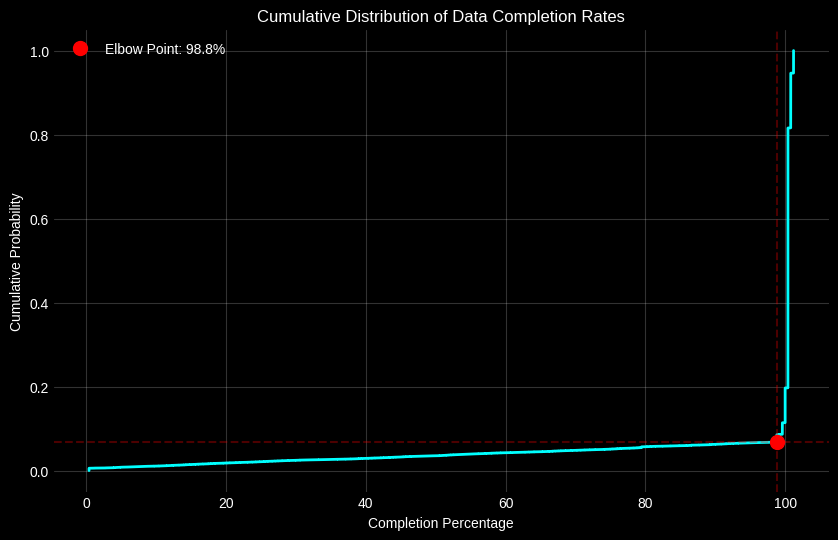

Suggested completion rate cutoff: 98.8%


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

def plot_completion_cdf(data, elbow_point=None):
    """Plot CDF in dark mode with optional elbow point."""
    # Set dark mode style
    plt.style.use('dark_background')
    
    # Sort data and calculate cumulative probabilities
    sorted_data = np.sort(data)
    cumulative_prob = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_data, cumulative_prob, 'cyan', linewidth=2)
    plt.grid(True, alpha=0.2)
    
    # If elbow point provided, mark it
    if elbow_point is not None:
        idx = np.where(sorted_data >= elbow_point)[0][0]
        plt.plot(elbow_point, cumulative_prob[idx], 'ro', markersize=10, 
                label=f'Elbow Point: {elbow_point:.1f}%')
        plt.axvline(x=elbow_point, color='r', linestyle='--', alpha=0.3)
        plt.axhline(y=cumulative_prob[idx], color='r', linestyle='--', alpha=0.3)
    
    # Customize plot
    plt.title('Cumulative Distribution of Data Completion Rates', fontsize=12)
    plt.xlabel('Completion Percentage', fontsize=10)
    plt.ylabel('Cumulative Probability', fontsize=10)
    
    if elbow_point is not None:
        plt.legend()
    
    plt.show()

def find_elbow_point(data):
    """Find the elbow point using the elbow/knee method."""
    # Prepare data points
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Normalize data to 0-1 range for both axes
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    points = np.column_stack((x_norm, y_norm))
    
    # First and last points
    start = points[0]
    end = points[-1]
    
    # Calculate distances from each point to the line
    # formed by the start and end points
    line_vec = end - start
    vec_from_start = points - start
    line_len = np.linalg.norm(line_vec)
    line_unitvec = line_vec / line_len
    point_line_proj = np.dot(vec_from_start, line_unitvec)
    point_line_proj_vec = np.outer(point_line_proj, line_unitvec)
    vec_to_line = vec_from_start - point_line_proj_vec
    
    # Calculate distances to line
    dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))
    
    # Find elbow point (point of maximum distance)
    elbow_idx = np.argmax(dist_to_line)
    
    # Return the actual completion percentage at the elbow point
    return np.sort(data)[elbow_idx]

# Use the functions
elbow = find_elbow_point(data_completion_rate["completion_percentage"])
plot_completion_cdf(data_completion_rate["completion_percentage"], elbow)

print(f"Suggested completion rate cutoff: {elbow:.1f}%")

In [15]:
len(data_completion_rate[data_completion_rate["completion_percentage"]>=98.8])/len(data_completion_rate)

0.9323173101839854

In [16]:
pd.read_sql_query("select count(1) ct from daily_prices", conn)

,ct
0,14977678


In [17]:
pd.read_sql_query("select * from daily_prices limit 1", conn).columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stock_splits', 'last_updated'],
      dtype='object')

In [18]:
# Get list of valid symbols and years
valid_combinations = data_completion_rate[data_completion_rate["completion_percentage"]>=98.8][["symbol","year"]]
# First, let's format our valid combinations for SQL
valid_pairs = valid_combinations.apply(
    lambda row: f"(symbol = '{row['symbol']}' AND strftime('%Y', date) = {row['year']})", 
    axis=1
)

# Calculate a safe chunk size (leaving room for the SQL expression overhead)
SAFE_CHUNK_SIZE = 800  # Starting with a conservative number below the 1000 limit

def process_in_chunks(valid_combinations, conn, chunk_size=SAFE_CHUNK_SIZE):
    chunks = []
    total_pairs = len(valid_combinations)
    
    # Process in chunks
    for start_idx in range(0, total_pairs, chunk_size):
        # Get chunk of valid combinations
        chunk_pairs = valid_combinations.iloc[start_idx:start_idx + chunk_size]
        
        # Create conditions for this chunk
        chunk_conditions = chunk_pairs.apply(
            lambda row: f"(symbol = '{row['symbol']}' AND strftime('%Y', date) = '{row['year']}')", 
            axis=1
        )
        conditions = " OR ".join(chunk_conditions)
        
        # Query for this chunk
        query = f"""
        SELECT *
        FROM daily_prices
        WHERE {conditions}
        """
        
        # Execute query and append results
        chunk_df = pd.read_sql_query(query, conn)
        chunks.append(chunk_df)
        
        # Optional: Print progress
        print(f"Processed {min(start_idx + chunk_size, total_pairs)}/{total_pairs} combinations")
    
    # Combine all chunks
    return pd.concat(chunks, ignore_index=True)

# Use the function
filtered_df = process_in_chunks(valid_combinations, conn)

Processed 800/57565 combinations
Processed 1600/57565 combinations
Processed 2400/57565 combinations
Processed 3200/57565 combinations
Processed 4000/57565 combinations
Processed 4800/57565 combinations
Processed 5600/57565 combinations
Processed 6400/57565 combinations
Processed 7200/57565 combinations
Processed 8000/57565 combinations
Processed 8800/57565 combinations
Processed 9600/57565 combinations
Processed 10400/57565 combinations
Processed 11200/57565 combinations
Processed 12000/57565 combinations
Processed 12800/57565 combinations
Processed 13600/57565 combinations
Processed 14400/57565 combinations
Processed 15200/57565 combinations
Processed 16000/57565 combinations
Processed 16800/57565 combinations
Processed 17600/57565 combinations
Processed 18400/57565 combinations
Processed 19200/57565 combinations
Processed 20000/57565 combinations
Processed 20800/57565 combinations
Processed 21600/57565 combinations
Processed 22400/57565 combinations
Processed 23200/57565 combination

In [19]:
filtered_df.to_parquet("complete_stock_data.parquet")

In [2]:
filtered_df = pd.read_parquet("complete_stock_data.parquet")

In [10]:
(filtered_df.memory_usage()/(1024**3)).sum()

np.float64(1.0797468312084675)

In [11]:
filtered_df

,date,symbol,open,high,low,close,volume,dividends,stock_splits,last_updated
0,1928-01-03,^GSPC,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0,2024-12-30 20:01:45.489297
1,1928-01-04,^GSPC,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0,2024-12-30 20:01:45.489297
2,1928-01-05,^GSPC,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0,2024-12-30 20:01:45.489297
3,1928-01-06,^GSPC,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,2024-12-30 20:01:45.489297
4,1928-01-09,^GSPC,17.500000,17.500000,17.500000,17.500000,0,0.0,0.0,2024-12-30 20:01:45.489297
...,...,...,...,...,...,...,...,...,...,...
14492110,2024-12-20,TETEU,12.150000,12.150000,12.150000,12.150000,0,0.0,0.0,2024-12-30 19:26:35.729779
14492111,2024-12-23,TETEU,12.150000,12.150000,12.150000,12.150000,0,0.0,0.0,2024-12-30 19:26:35.729779
14492112,2024-12-24,TETEU,12.230000,12.230000,12.230000,12.230000,100,0.0,0.0,2024-12-30 19:26:35.729779
14492113,2024-12-26,TETEU,12.230000,12.230000,12.230000,12.230000,0,0.0,0.0,2024-12-30 19:26:35.729779


In [12]:
# Basic data quality checks and statistics
def analyze_dataset(df):
    # Convert date if not already datetime
    df['date'] = pd.to_datetime(df['date'])
    
    print("Dataset Overview:")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
    print(f"Number of unique symbols: {df['symbol'].nunique()}")
    print(f"Total number of records: {len(df):,}")
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        print(missing[missing > 0])
    
    # Basic statistics for numerical columns
    print("\nBasic Statistics:")
    print(df.describe())
    
    # Check for extreme values
    print("\nPotential Outliers (99th percentile):")
    numeric_cols = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_cols:
        q99 = df[col].quantile(0.99)
        print(f"{col}: {q99:,.2f}")

analyze_dataset(filtered_df)

Dataset Overview:
Date Range: 1928-01-03 00:00:00 to 2024-12-31 00:00:00
Number of unique symbols: 3676
Total number of records: 14,492,115

Missing Values:
open     1
high     1
low      1
close    1
dtype: int64

Basic Statistics:
                                date          open          high  \
count                       14492115  1.449211e+07  1.449211e+07   
mean   2010-07-28 19:59:39.810152192  3.392587e+06  3.529313e+06   
min              1928-01-03 00:00:00 -4.106038e+00 -4.254311e+00   
25%              2003-04-14 00:00:00  4.460000e+00  4.700000e+00   
50%              2013-06-27 00:00:00  1.279597e+01  1.315000e+01   
75%              2020-07-17 00:00:00  3.407870e+01  3.496150e+01   
max              2024-12-31 00:00:00  1.356750e+11  1.370250e+11   
std                              NaN  3.702111e+08  3.852849e+08   

                low         close        volume     dividends  stock_splits  
count  1.449211e+07  1.449211e+07  1.449212e+07  1.449212e+07  1.449212e+07 

In [19]:
(filtered_df["low"]<=0).sum()/len(filtered_df)

np.float64(9.660425686657882e-07)

In [21]:
(filtered_df["low"]<=0).sum()

np.int64(14)

In [22]:
(filtered_df["high"]<=0).sum()/len(filtered_df)

np.float64(3.4501520309492435e-07)

In [23]:
(filtered_df["high"]<=0).sum()

np.int64(5)

In [24]:
filtered_df.loc[(filtered_df["low"] <= 0) | (filtered_df["high"] <= 0)]

,date,symbol,open,high,low,close,volume,dividends,stock_splits,last_updated
5396172,2008-01-31,RCAT,1800.000000,1800.000000,0.000000,1800.000000,0,0.00,0.0,2024-12-30 19:49:43.009756
5396317,2008-08-27,RCAT,0.000000,1800.000000,0.000000,1800.000000,1,0.00,0.0,2024-12-30 19:49:43.009756
5396368,2008-11-07,RCAT,1800.000000,1800.000000,0.000000,1800.000000,1,0.00,0.0,2024-12-30 19:49:43.009756
5768277,2009-04-14,RCAT,1800.000000,3600.000000,0.000000,3600.000000,0,0.00,0.0,2024-12-30 19:49:43.009756
5768308,2009-05-28,RCAT,0.000000,1800.000000,0.000000,1800.000000,0,0.00,0.0,2024-12-30 19:49:43.009756
5768385,2009-09-16,RCAT,1800.000000,1800.000000,0.000000,1800.000000,0,0.00,0.0,2024-12-30 19:49:43.009756
5768437,2009-11-30,RCAT,1800.000000,1800.000000,0.000000,1800.000000,1,0.00,0.0,2024-12-30 19:49:43.009756
6146713,2010-01-05,RCAT,3600.000000,7200.000000,0.000000,3600.000000,1,0.00,0.0,2024-12-30 19:49:43.009756
6941108,2012-12-28,RCAT,0.000000,5400.000000,0.000000,5400.000000,0,0.00,0.0,2024-12-30 19:49:43.009756
13932071,2024-03-15,LENZ,-4.055346,-4.254311,-3.738522,-4.232767,829500,7.21,0.0,2024-12-30 19:05:03.791555


In [3]:
def validate_stock_data(df):
    print("Data Validation Report\n")
    
    # 1. Basic Price Validations
    price_issues = df[(df[['open', 'high', 'low', 'close']] <= 0).any(axis=1)]
    print(f"1. Records with zero or negative prices: {len(price_issues)}")
    
    # 2. Logic Validations
    illogical_prices = df[
        (df['low'] > df['high']) |  # Low should never be higher than high
        (df['open'] > df['high']) |  # Open should never be higher than high
        (df['open'] < df['low']) |   # Open should never be lower than low
        (df['close'] > df['high']) | # Close should never be higher than high
        (df['close'] < df['low'])    # Close should never be lower than low
    ]
    print(f"2. Records with illogical price relationships: {len(illogical_prices)}")
    if len(illogical_prices) > 0:
        print("\nSample of illogical prices:")
        print(illogical_prices.head())
    
    # 3. Check for extreme price changes (potential split issues)
    df['price_change'] = df.groupby('symbol')['close'].pct_change()
    extreme_changes = df[abs(df['price_change']) > 0.5]  # 50% daily change
    print(f"\n3. Records with extreme price changes (>50%): {len(extreme_changes)}")
    if len(extreme_changes) > 0:
        print("\nTop extreme changes:")
        print(extreme_changes.nlargest(5, 'price_change')[['symbol', 'date', 'price_change']])
    
    # 4. Volume Validations
    zero_volume = df[df['volume'] == 0]
    print(f"\n4. Records with zero volume: {len(zero_volume)}")
        
    # 5. Check for duplicate dates
    duplicates = df.groupby(['symbol', 'date']).size().reset_index(name='count')
    duplicates = duplicates[duplicates['count'] > 1]
    print(f"\n5. Number of duplicate date entries: {len(duplicates)}")
    
    # 6. Stock Splits Validation
    splits = df[df['stock_splits'] != 0]
    print(f"\n6. Number of stock split events: {len(splits)}")
    if len(splits) > 0:
        print("\nSample of split events:")
        print(splits[['symbol', 'date', 'stock_splits']].head())
    
    return {
        'price_issues': price_issues,
        'illogical_prices': illogical_prices,
        'extreme_changes': extreme_changes,
        'zero_volume': zero_volume,
        #'gaps': gaps,
        'duplicates': duplicates,
        'splits': splits
    }

# Run validation
validation_results = validate_stock_data(filtered_df)

Data Validation Report

1. Records with zero or negative prices: 511533
2. Records with illogical price relationships: 599290

Sample of illogical prices:
            date symbol  open      high       low     close  volume  \
8020  1962-01-02    AEP   0.0  0.954654  0.932571  0.932571    5800   
8021  1962-01-03    AEP   0.0  0.944462  0.925777  0.930873   10200   
8022  1962-01-04    AEP   0.0  0.932571  0.917283  0.917283    8800   
8023  1962-01-05    AEP   0.0  0.913884  0.886706  0.896898   11400   
8024  1962-01-08    AEP   0.0  0.901995  0.869720  0.890104   17200   

      dividends  stock_splits                last_updated  
8020        0.0           0.0  2024-12-30 20:23:40.248057  
8021        0.0           0.0  2024-12-30 20:23:40.248057  
8022        0.0           0.0  2024-12-30 20:23:40.248057  
8023        0.0           0.0  2024-12-30 20:23:40.248057  
8024        0.0           0.0  2024-12-30 20:23:40.248057  


/tmp/ipykernel_115494/1481902634.py:22: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['price_change'] = df.groupby('symbol')['close'].pct_change()



3. Records with extreme price changes (>50%): 9568

Top extreme changes:
         symbol        date  price_change
13652406   BHST  2024-06-04   5998.999715
7909174    ABVC  2015-09-17   4165.667189
10916152   NCPL  2020-11-11   2665.666750
9112612     IPA  2017-01-03    874.000020
7523465    BTCS  2014-02-06    660.999983

4. Records with zero volume: 724963

5. Number of duplicate date entries: 0

6. Number of stock split events: 4775

Sample of split events:
      symbol        date  stock_splits
8231     AEP  1962-10-31          2.00
9270     CVX  1962-12-17          1.05
9523     DIS  1962-12-18          1.03
11771     IP  1962-11-19          1.02
15421    CNP  1963-05-20          3.00


In [13]:
filtered_df["date"] = pd.to_datetime(filtered_df["date"])

In [14]:
zero_opens = filtered_df[filtered_df["open"]==0]

In [16]:
len(zero_opens)/len(filtered_df)

0.03529657334350438

In [18]:
zero_open_stats = zero_opens.groupby(["symbol"]).agg({"date":["count", "min", "max"], "close": ["min", "max"], "volume": "mean"})

In [19]:
zero_open_stats

date                              close                     volume
       count        min        max          min          max          mean
symbol                                                                    
AAME    1377 1981-01-02 1986-11-03     3.450257    14.159494  9.398693e+03
ABT      571 1981-01-02 1983-04-05     0.247424     0.459884  4.737983e+06
ACNT    2592 1981-01-02 1991-11-08     0.863347     4.361471  1.520975e+04
ADBE      48 1987-01-02 1987-03-11     0.381443     0.869248  4.153733e+06
ADI      897 1981-01-02 1984-07-18     0.490652     2.453263  2.098777e+05
...      ...        ...        ...          ...          ...           ...
XOMA     570 1987-01-02 1989-04-04  2250.000000  9600.000000  2.698281e+02
XRAY     739 1988-01-04 1991-04-24     0.430272     1.158422  8.463816e+04
XRX     3529 1962-01-02 1976-12-31     0.395101    11.890156  2.292489e+05
ZION    2237 1981-01-02 1990-03-23     1.072088     3.242414  5.371247e+04
^GSPC   4849 1962-01-02 1982-04-19    52.320000   140.520004  1.821019e+07

[356 rows x 6 columns]

In [29]:
zero_open_stats["symbol_count"] = filtered_df.groupby(["symbol"])[["date"]].count().rename(columns={"date":"symbol_count"})

In [32]:
(zero_open_stats[("date","count")]/zero_open_stats["symbol_count"]).describe()

count    356.000000
mean       0.125039
std        0.072273
min        0.000083
25%        0.068161
50%        0.112654
75%        0.181622
max        0.327424
dtype: float64

In [34]:
len(zero_open_stats)/filtered_df["symbol"].nunique()

0.09684439608269858